In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy import stats
import pylab as plt
import torch
import swyft
from simulators import SimulatorLinePattern

/home/cweniger/.pyenv/versions/3.10.11/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
bounds = None
SIGMA = 0.3
randn_realizations = np.random.randn(10000, 256, 256)

[8.79191762e-04 8.79189646e-04 1.23138976e-03 9.85632555e-05
 5.87495319e-04]


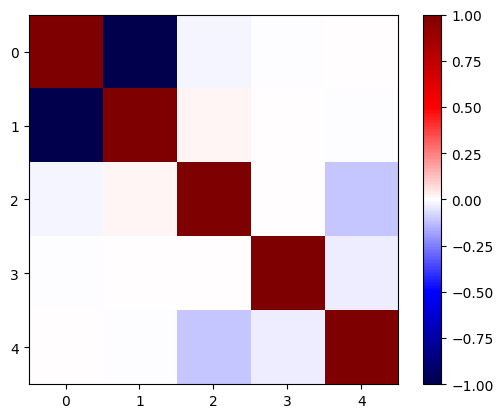

In [75]:
def fisher(z0, epsilon):
    dmu = []
    n = len(z0)
    for i in range(n):
        dz = np.zeros(len(z0))
        dz[i] = epsilon
        temp = sim.sample(conditions = dict(z = z0+dz))['mu'] - sim.sample(conditions = dict(z = z0))['mu']
        dmu.append(temp)
    Q = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            Q[i, j] = (dmu[i]*dmu[j]).sum()/epsilon**2
    return Q/sim.sigma**2

z0 = np.array([-0.6, -0.6, -0.7, -.8, 0.3])
Q = fisher(z0, 1e-5)
Cov = np.linalg.inv(Q)
std = np.diagonal(Cov)**0.5
Rho = np.diag(1/std).dot(Cov).dot(np.diag(1/std))
plt.imshow(Rho, vmin = -1, vmax = 1, cmap = 'seismic')
plt.colorbar()
print(std)

bounds_fisher = np.array([[z0[i]-10*std[i], z0[i]+10*std[i]] for i in range(5)])

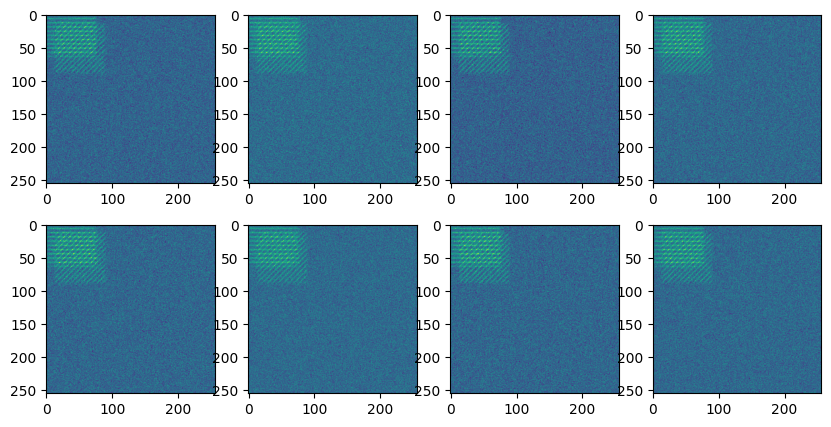

In [83]:
sim = SimulatorLinePattern(bounds = bounds, sigma = SIGMA)
plt.figure(figsize = (10, 5))
z0 = np.array([-0.6, -0.6, -0.7, -.8, 0.3])
#z0 = np.array([-0.2, -0.2, -0.4, -.4, 0.3])
sample0 = sim.sample(conditions = dict(z = z0))
mu0 = sample0['mu']
for i in range(1, 9):
    plt.subplot(2, 4, i)
    if i == 1:
        sample = sample0
    else:
        sample = sim.sample()
    x = sample['x']
    plt.imshow(x)

In [84]:
class Network(swyft.SwyftModule):
    def __init__(self, prefix = ""):
        super().__init__()
        self.logratios = swyft.LogRatioEstimator_1dim(num_features = 4, num_params = 5, varnames = 'z',
                                                      dropout = 0.1, use_batch_norm = True, num_blocks = 4, hidden_features = 128)
        self.optimizer_init = swyft.AdamOptimizerInit(lr=1e-3, lrs_factor=0.3, lrs_patience=3)
        self.norm = swyft.networks.OnlineStandardizingLayer((256, 256))
        self.fnorm = swyft.networks.OnlineStandardizingLayer((256, 256, 2))
        self.CNN = torch.nn.Sequential(
            torch.nn.LazyConv2d(4, 3), torch.nn.ReLU(), torch.nn.MaxPool2d(2), torch.nn.LazyBatchNorm2d(affine = False, momentum = 0.01),
            torch.nn.LazyConv2d(8, 3), torch.nn.ReLU(), torch.nn.MaxPool2d(2), torch.nn.LazyBatchNorm2d(affine = False, momentum = 0.01),
            torch.nn.LazyConv2d(16, 3), torch.nn.ReLU(), torch.nn.MaxPool2d(2), torch.nn.LazyBatchNorm2d(affine = False, momentum = 0.01),
            torch.nn.LazyConv2d(32, 3), torch.nn.ReLU(), torch.nn.MaxPool2d(2), torch.nn.LazyBatchNorm2d(affine = False, momentum = 0.01),
            torch.nn.LazyConv2d(64, 3), torch.nn.ReLU(), torch.nn.MaxPool2d(2), torch.nn.LazyBatchNorm2d(affine = False, momentum = 0.01),            
        )
        self.CNN_to_MLP = torch.nn.LazyLinear(1024)
        self.MLP = torch.nn.Sequential(
            swyft.networks.channelized.LinearWithChannel(5, 1024, 256), torch.nn.ReLU(),
            swyft.networks.channelized.LinearWithChannel(5, 256, 128), torch.nn.ReLU(),
            swyft.networks.channelized.LinearWithChannel(5, 128, 2)
        )
        
        self.linear_embedding = torch.nn.LazyLinear(10)

        self.prefix = ""

    def forward(self, A, B):
        xA = A['x']
        x = self.norm(xA)

        fx = torch.fft.fft2(xA)
        fx = torch.stack([fx.real, fx.imag], dim=-1)
        fx = self.fnorm(fx)

        f1 = self.CNN(x.unsqueeze(1))
        f1 = self.CNN_to_MLP(torch.flatten(f1, start_dim = 1)).unsqueeze(1).expand(-1, 5, -1)
        f1 = self.MLP(f1).view(-1, 5, 2)
        f2 = self.linear_embedding(torch.flatten(fx, start_dim=1)).view(-1, 5, 2)
        f = torch.cat([f1, f2], dim=-1)
       
        z = B[self.prefix+'z']
        
        logratios = self.logratios(f, z)
        return logratios, f, z
    
    def bounds(self, logratios):
        bounds = swyft.collect_rect_bounds(logratios, 'z', (5,), threshold = 1e-6)
        return bounds

In [85]:
# Simulate
# Infer + get bounds
Nsims = 8192*2

# Simulate
sim = SimulatorLinePattern(bounds = bounds, sigma = SIGMA, randn_realizations = randn_realizations)
samples = sim.sample(Nsims)
prior_samples = sim.sample(N = 10000, targets = ['z'])

100%|████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2016.08it/s]


In [86]:
resampler = sim.get_resampler(targets = ['x'])

In [90]:
trainer = swyft.SwyftTrainer(accelerator = 'gpu', max_epochs = 50, precision = 32)
net = Network(prefix="")  # Instantiate network
dl = swyft.SwyftDataModule(samples, fractions = [0.8, 0.2, 0], batch_size = 256, on_after_load_sample = resampler)
trainer.fit(net, dl)
logratios = trainer.infer(net, sample0, prior_samples)
#        bounds[prefix] = net.bounds(logratios)
#        bounds = bounds[prefix]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                     | Params
--------------------------------------------------------------
0 | logratios        | LogRatioEstimator_1dim   | 664 K 
1 | norm             | OnlineStandardizingLayer | 0     
2 | fnorm            | OnlineStandardizingLayer | 0     
3 | CNN              | Sequential               | 0     
4 | CNN_to_MLP       | LazyLinear               | 0     
5 | MLP              | Sequential

Epoch 0:  80%|███████████████████████████████████████████████▏           | 52/65 [00:07<00:01,  7.07it/s, loss=-0.426, v_num=183]
Validation: 0it [00:00, ?it/s]
Epoch 1:  80%|████████████████████████████████        | 52/65 [00:07<00:01,  7.18it/s, loss=-0.623, v_num=183, val_loss=0.000909]
Validation: 0it [00:00, ?it/s]
Epoch 2:  80%|████████████████████████████████▊        | 52/65 [00:07<00:01,  7.19it/s, loss=-0.753, v_num=183, val_loss=0.00031]
Validation: 0it [00:00, ?it/s]
Epoch 3:  80%|████████████████████████████████▊        | 52/65 [00:07<00:01,  7.25it/s, loss=-0.879, v_num=183, val_loss=-.00518]
Validation: 0it [00:00, ?it/s]
Epoch 4:  80%|██████████████████████████████████▍        | 52/65 [00:07<00:01,  7.16it/s, loss=-0.974, v_num=183, val_loss=-.105]
Validation: 0it [00:00, ?it/s]
Epoch 5:  80%|███████████████████████████████████▏        | 52/65 [00:07<00:01,  7.14it/s, loss=-1.14, v_num=183, val_loss=-.344]
Validation: 0it [00:00, ?it/s]
Epoch 6:  80%|████████████████████

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|███████████████████████████████████████████| 65/65 [00:08<00:00,  7.30it/s, loss=-3.86, v_num=183, val_loss=-3.85]

You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 75.94it/s]


### Batchnorm, 4 layers, 8k training, 0.1 dropout, yes fft, round 5

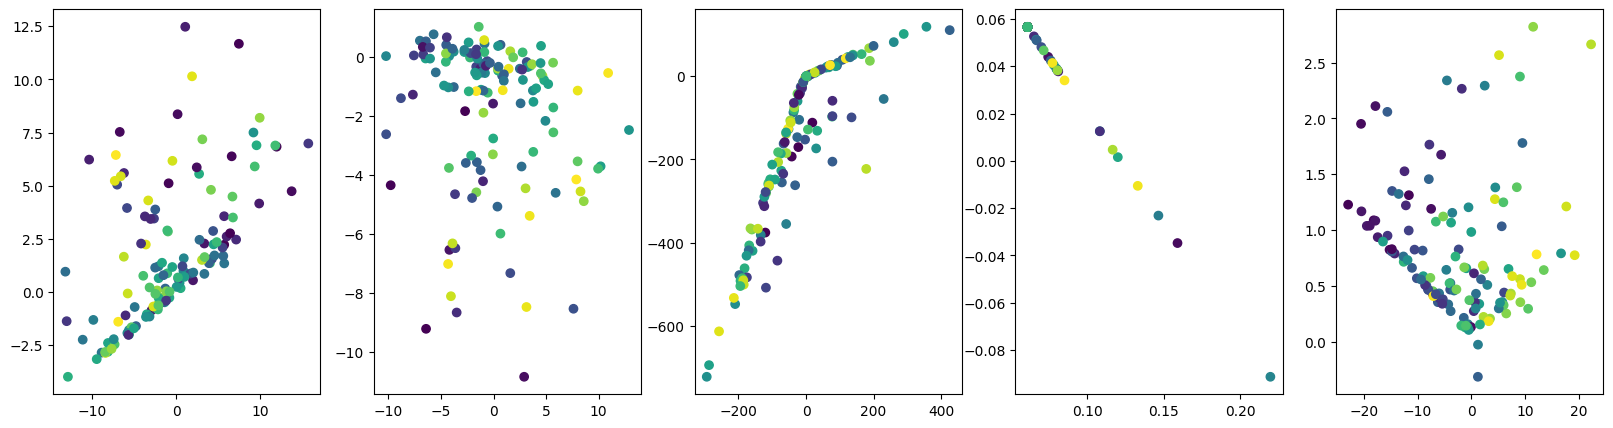

In [95]:
#logratios2 = trainer.infer(net, samples, samples, return_sample_ratios = False, batch_size = 128)
f = logratios2[0][1][:,:]
z = logratios2[0][2]
plt.figure(figsize=(20, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
#    plt.scatter(z[:,i], f[:,i,0])
    plt.scatter(f[:,i,0], f[:,i,1], c = z[:,i])

You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 74.88it/s]


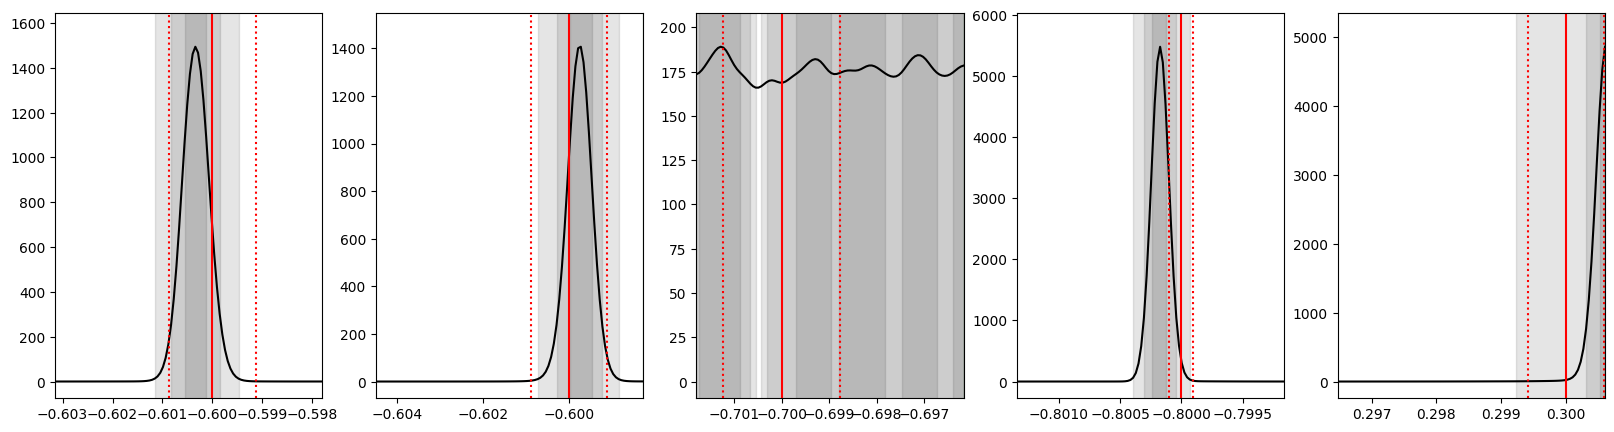

In [92]:
logratios = trainer.infer(net, sample0, prior_samples)
plt.figure(figsize = (20, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    j = i
    swyft.plot_1d(logratios, "z[%i]"%j, ax = plt.gca(), smooth = 3, bins = 100)
#    plt.gca().set_yscale('log')
#    plt.gca().set_ylim([1e-10, 1e2])
    plt.axvline(sample0['z'][j], c = 'r', ls='-')
    plt.axvline(sample0['z'][j]-std[j], c='r', ls=':')
    plt.axvline(sample0['z'][j]+std[j], c='r', ls=':')
    plt.axvline(bounds[j,0], c = 'g')
    plt.axvline(bounds[j,1], c = 'g')

### Batchnorm, 4 layers, 8k training, 0.1 dropout, yes fft, round 4

You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████████| 64/64 [00:02<00:00, 21.42it/s]


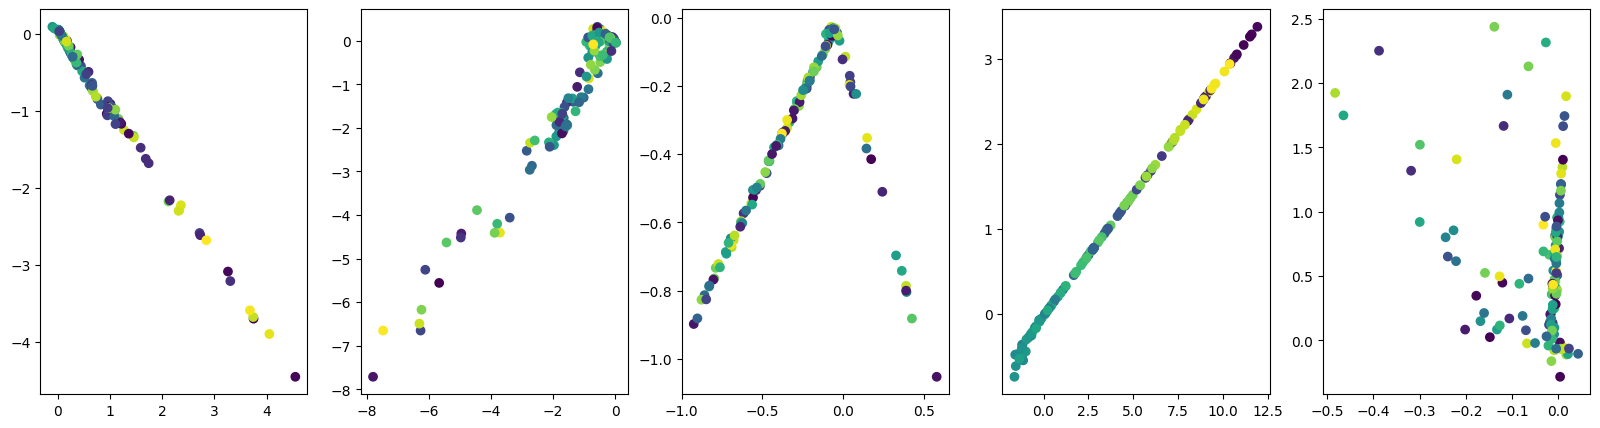

In [65]:
logratios2 = trainer.infer(net, samples, samples, return_sample_ratios = False, batch_size = 128)
f = logratios2[0][1][:,:]
z = logratios2[0][2]
plt.figure(figsize=(20, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
#    plt.scatter(z[:,i], f[:,i,0])
    plt.scatter(f[:,i,0], f[:,i,1], c = z[:,i])

You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 79.96it/s]


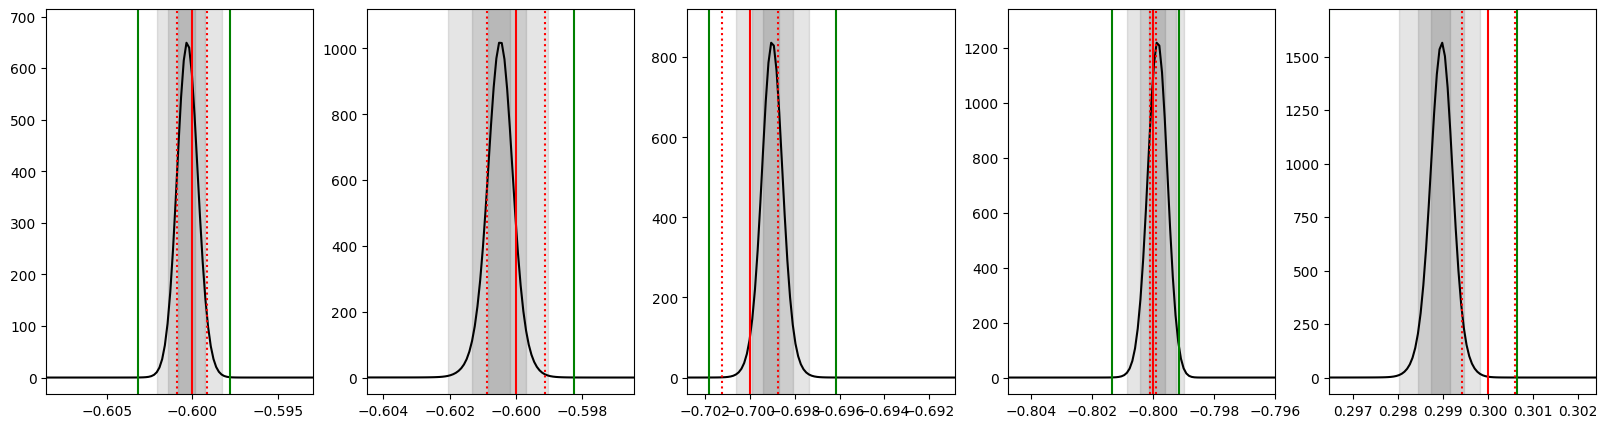

In [82]:
logratios = trainer.infer(net, sample0, prior_samples)
plt.figure(figsize = (20, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    j = i
    swyft.plot_1d(logratios, "z[%i]"%j, ax = plt.gca(), smooth = 3, bins = 100)
#    plt.gca().set_yscale('log')
#    plt.gca().set_ylim([1e-10, 1e2])
    plt.axvline(sample0['z'][j], c = 'r', ls='-')
    plt.axvline(sample0['z'][j]-std[j], c='r', ls=':')
    plt.axvline(sample0['z'][j]+std[j], c='r', ls=':')
    plt.axvline(bounds[j,0], c = 'g')
    plt.axvline(bounds[j,1], c = 'g')

### Batchnorm, 4 layers, 8k training, 0.1 dropout, YES fft, round 3

You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0:  12%|████████▋                                                            | 1/8 [00:41<04:48, 41.26s/it]
Predicting: 64it [00:02, 12.79it/s] 


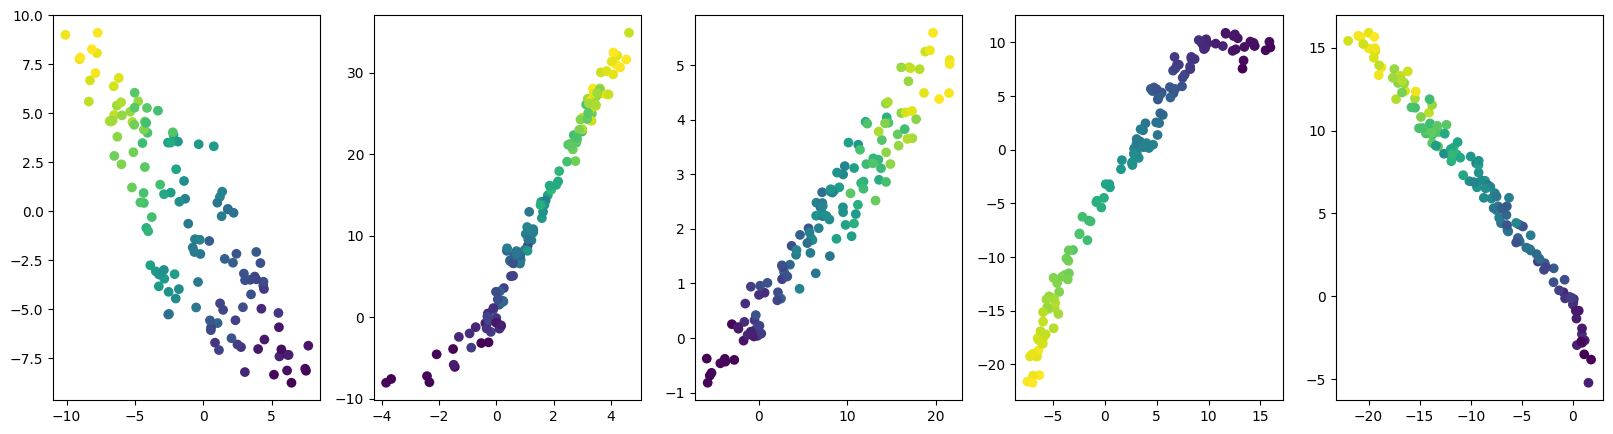

In [51]:
logratios2 = trainer.infer(net, samples, samples, return_sample_ratios = False, batch_size = 128)
f = logratios2[0][1][:,:]
z = logratios2[0][2]
plt.figure(figsize=(20, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
#    plt.scatter(z[:,i], f[:,i,0])
    plt.scatter(f[:,i,0], f[:,i,1], c = z[:,i])

You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 80.68it/s]


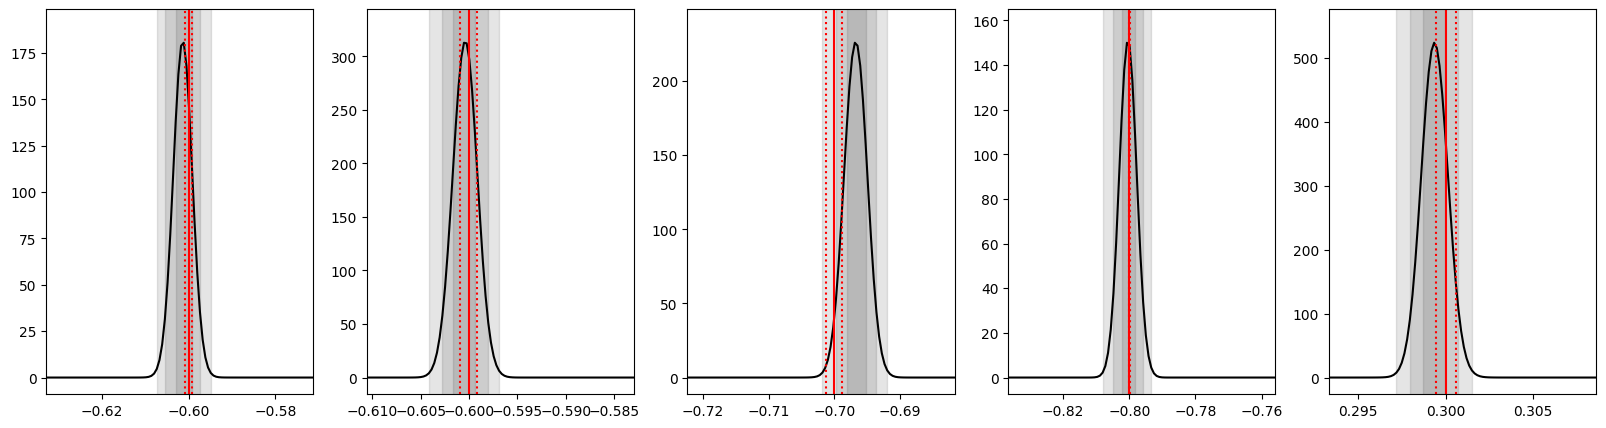

In [54]:
logratios = trainer.infer(net, sample0, prior_samples)
plt.figure(figsize = (20, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    j = i
    swyft.plot_1d(logratios, "z[%i]"%j, ax = plt.gca(), smooth = 3, bins = 100)
#    plt.gca().set_yscale('log')
#    plt.gca().set_ylim([1e-10, 1e2])
    plt.axvline(sample0['z'][j], c = 'r', ls='-')
    plt.axvline(sample0['z'][j]-std[j], c='r', ls=':')
    plt.axvline(sample0['z'][j]+std[j], c='r', ls=':')

### Batchnorm, 4 layers, 8k training, 0.1 dropout, no fft, round 3

You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.45it/s]


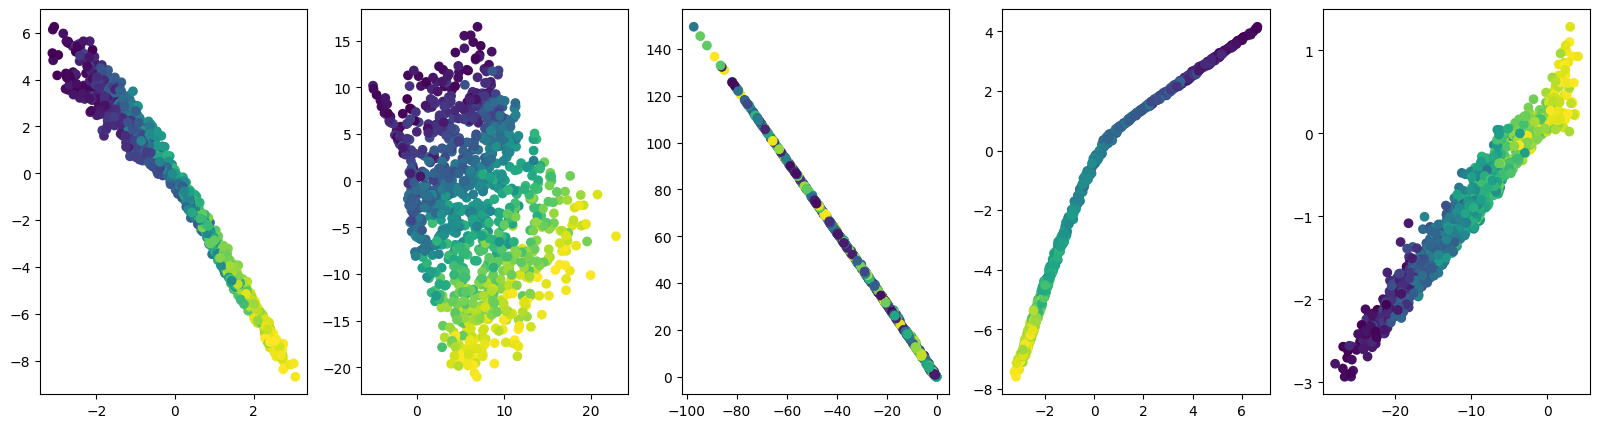

In [44]:
logratios2 = trainer.infer(net, samples, samples, return_sample_ratios = False, batch_size = 1024)
f = logratios2[0][1][:,:]
z = logratios2[0][2]
plt.figure(figsize=(20, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
#    plt.scatter(z[:,i], f[:,i,0])
    plt.scatter(f[:,i,0], f[:,i,1], c = z[:,i])

You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 71.70it/s]


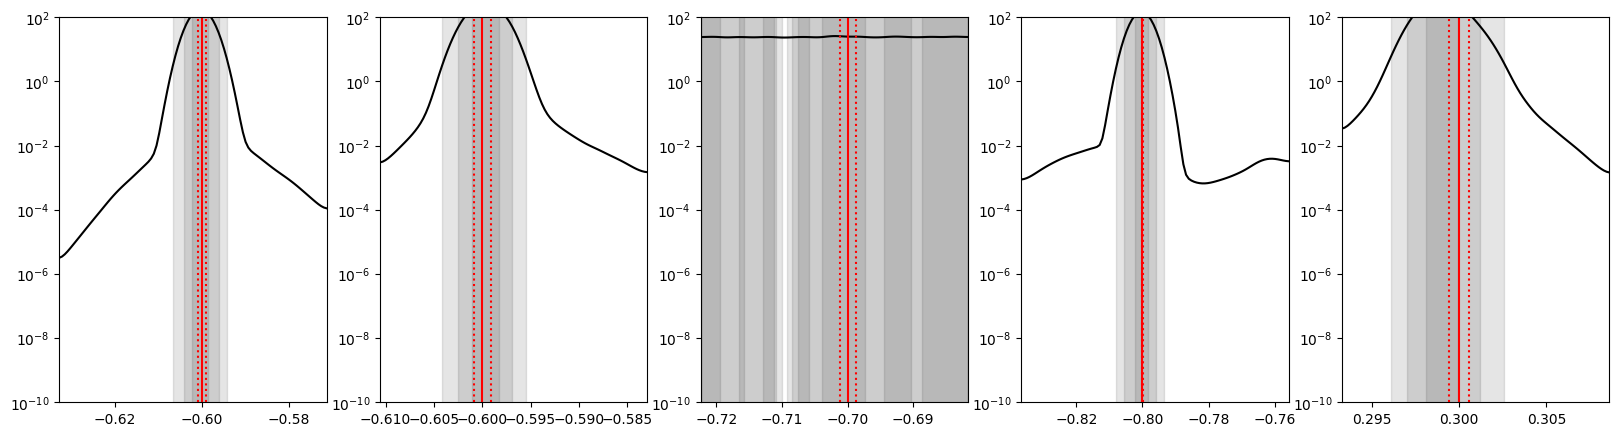

In [46]:
logratios = trainer.infer(net, sample0, prior_samples)
plt.figure(figsize = (20, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    j = i
    swyft.plot_1d(logratios, "z[%i]"%j, ax = plt.gca(), smooth = 3, bins = 100)
#    plt.gca().set_yscale('log')
#    plt.gca().set_ylim([1e-10, 1e2])
    plt.axvline(sample0['z'][j], c = 'r', ls='-')
    plt.axvline(sample0['z'][j]-std[j], c='r', ls=':')
    plt.axvline(sample0['z'][j]+std[j], c='r', ls=':')

### Batchnorm, 4 layers, 8k training, 0.1 dropout, no fft, round 2

You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.44it/s]


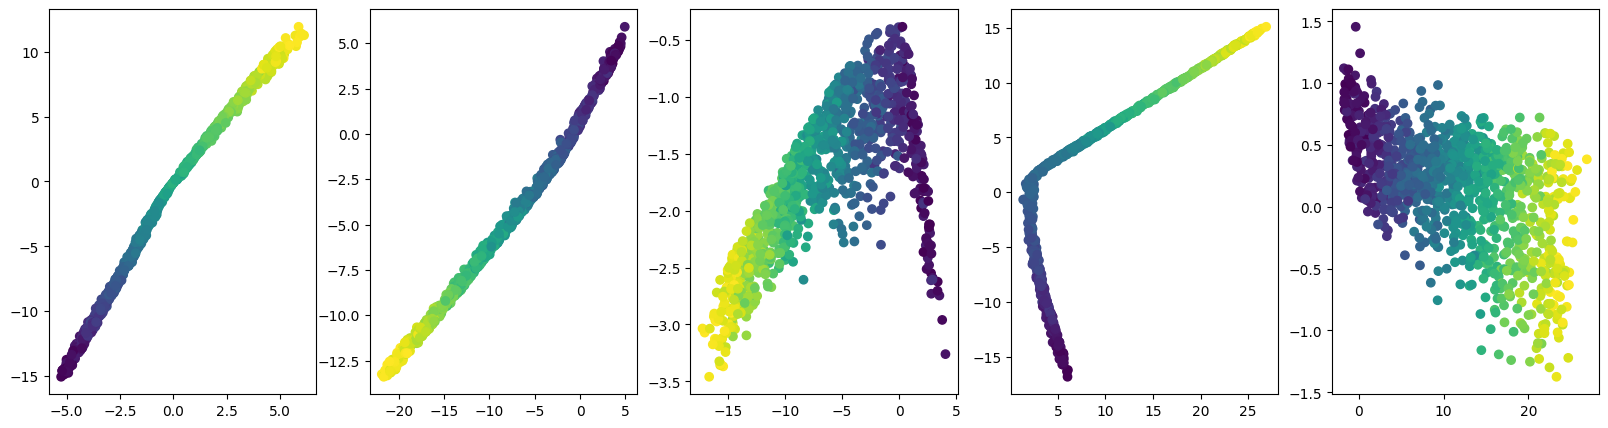

In [35]:
logratios2 = trainer.infer(net, samples, samples, return_sample_ratios = False, batch_size = 1024)
f = logratios2[0][1][:,:]
z = logratios2[0][2]
plt.figure(figsize=(20, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
#    plt.scatter(z[:,i], f[:,i,0])
    plt.scatter(f[:,i,0], f[:,i,1], c = z[:,i])

You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 81.60it/s]


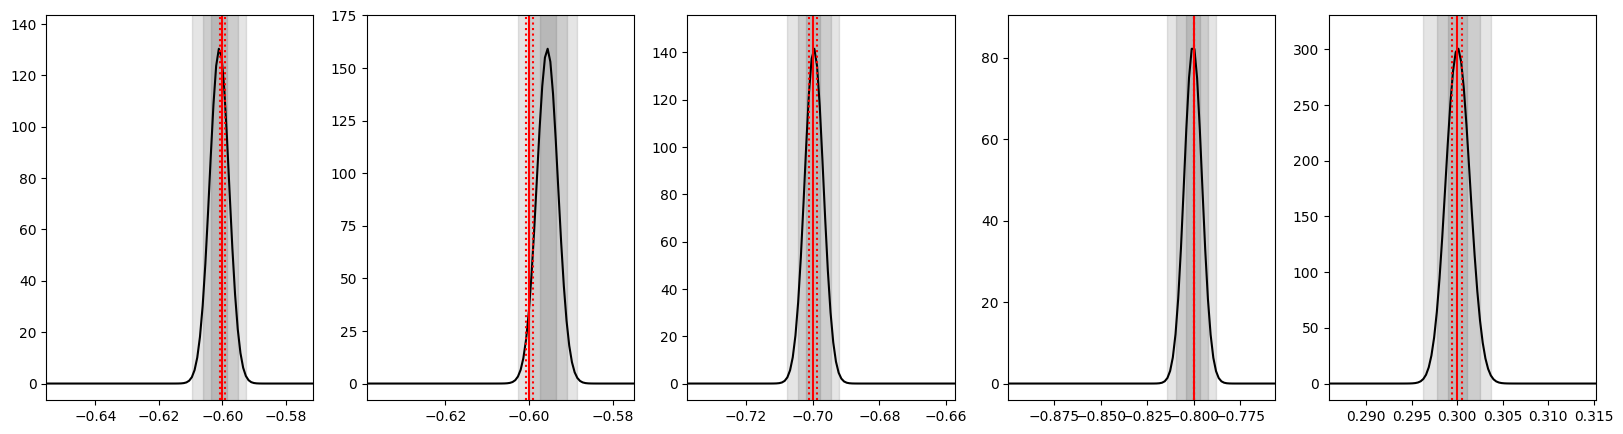

In [38]:
logratios = trainer.infer(net, sample0, prior_samples)
plt.figure(figsize = (20, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    j = i
    swyft.plot_1d(logratios, "z[%i]"%j, ax = plt.gca(), smooth = 3, bins = 100)
#    plt.gca().set_yscale('log')
#    plt.gca().set_ylim([1e-10, 1e2])
    plt.axvline(sample0['z'][j], c = 'r', ls='-')
    plt.axvline(sample0['z'][j]-std[j], c='r', ls=':')
    plt.axvline(sample0['z'][j]+std[j], c='r', ls=':')

### Batchnorm, 4 layers, 8k training, 0.1 dropout, no fft, round 1

You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.54it/s]


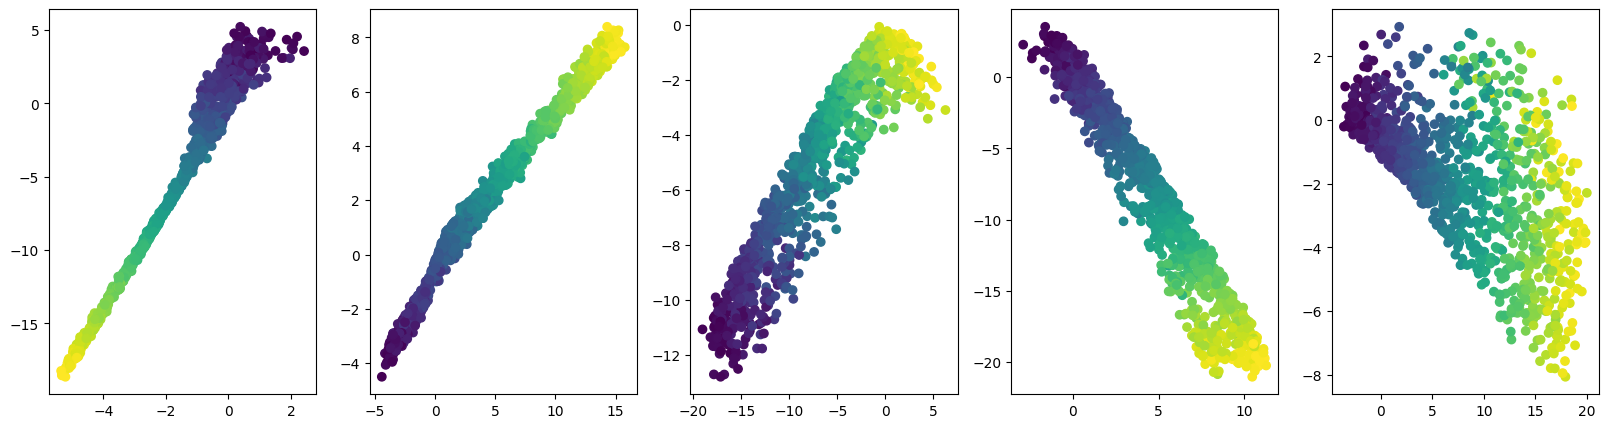

In [24]:
logratios2 = trainer.infer(net, samples, samples, return_sample_ratios = False, batch_size = 1024)
f = logratios2[0][1][:,:]
z = logratios2[0][2]
plt.figure(figsize=(20, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
#    plt.scatter(z[:,i], f[:,i,0])
    plt.scatter(f[:,i,0], f[:,i,1], c = z[:,i])

You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 76.64it/s]


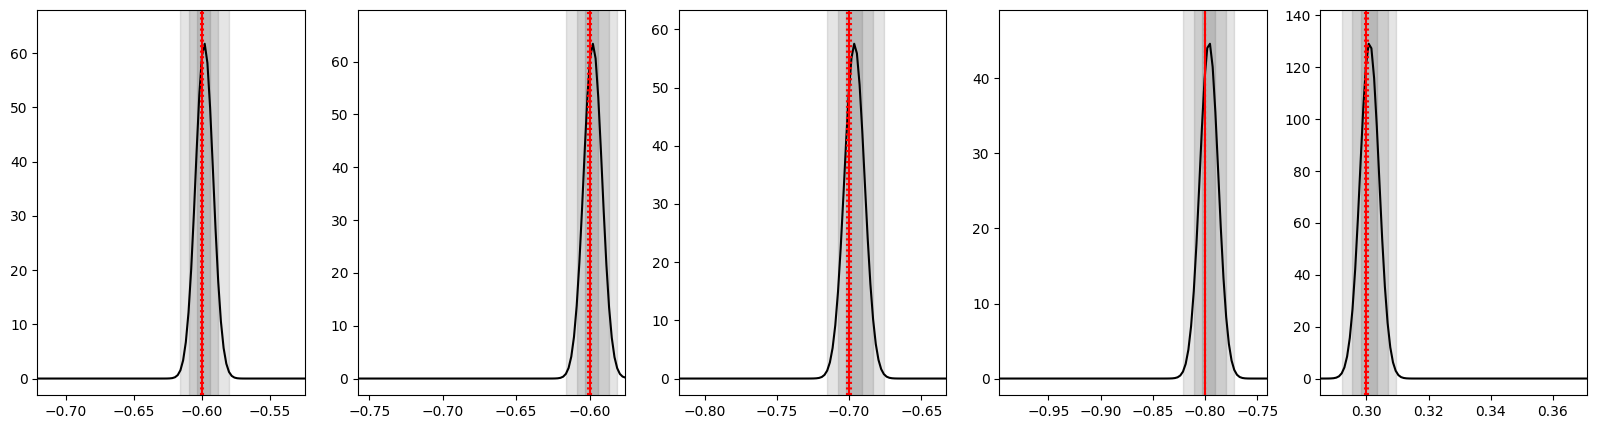

In [25]:
logratios = trainer.infer(net, sample0, prior_samples)
plt.figure(figsize = (20, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    j = i
    swyft.plot_1d(logratios, "z[%i]"%j, ax = plt.gca(), smooth = 3, bins = 100)
#    plt.gca().set_yscale('log')
#    plt.gca().set_ylim([1e-10, 1e2])
    plt.axvline(sample0['z'][j], c = 'r', ls='-')
    plt.axvline(sample0['z'][j]-std[j], c='r', ls=':')
    plt.axvline(sample0['z'][j]+std[j], c='r', ls=':')

### Batchnorm, 4 layers, 8k training, 0.1 dropout, no fft, round 0

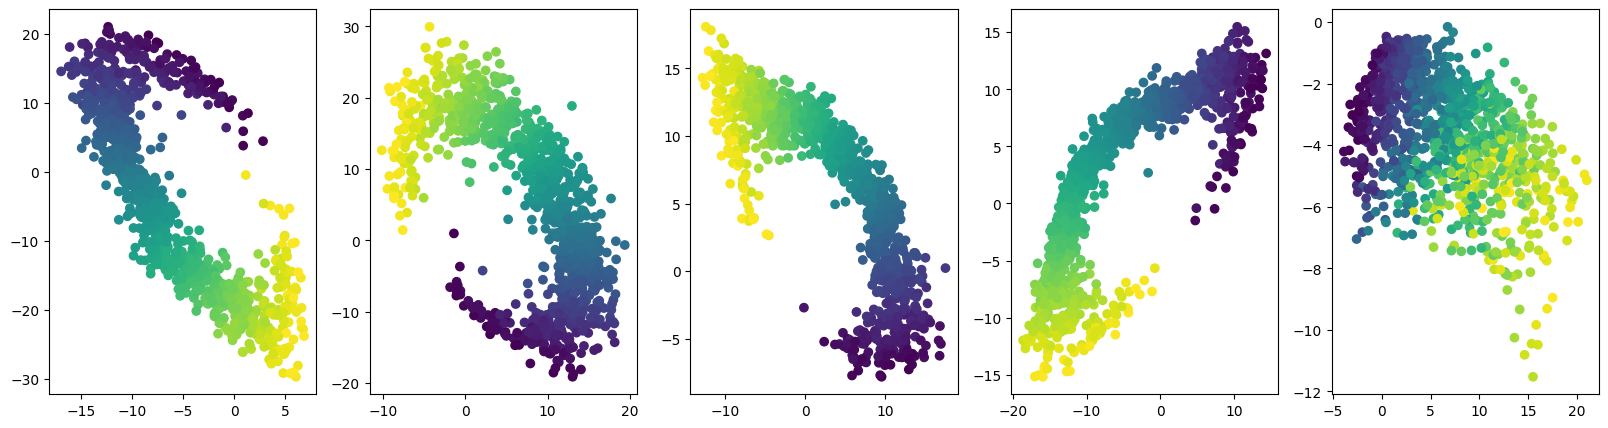

In [14]:
logratios2 = trainer.infer(net, samples, samples, return_sample_ratios = False, batch_size = 1024)
f = logratios2[0][1][:,:]
z = logratios2[0][2]
plt.figure(figsize=(20, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
#    plt.scatter(z[:,i], f[:,i,0])
    plt.scatter(f[:,i,0], f[:,i,1], c = z[:,i])

You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 80.32it/s]


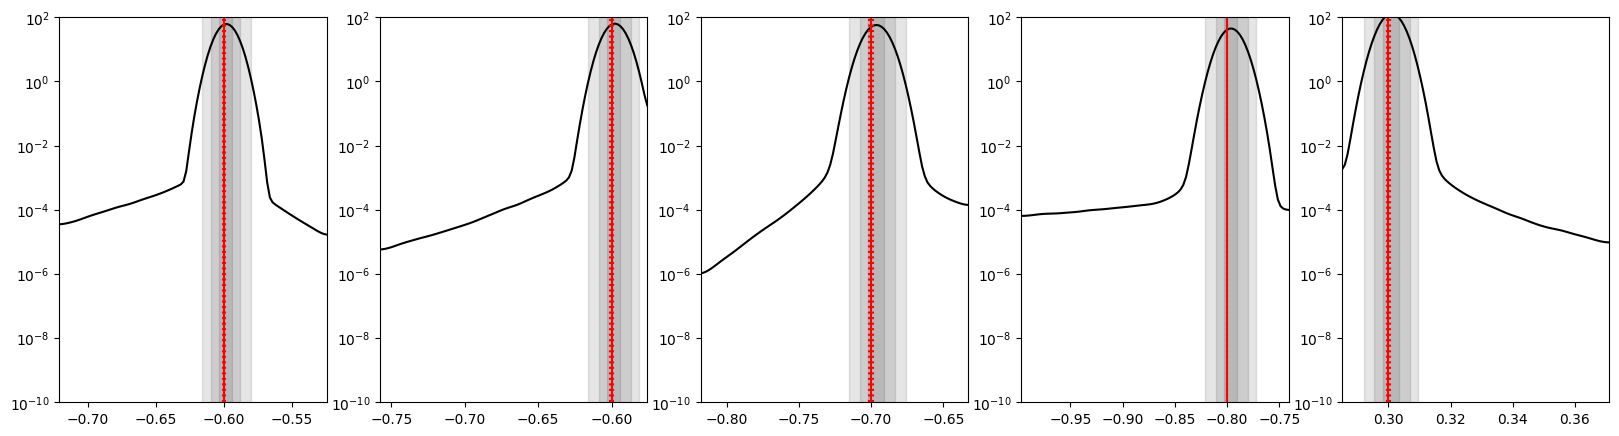

In [28]:
logratios = trainer.infer(net, sample0, prior_samples)
plt.figure(figsize = (20, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    j = i
    swyft.plot_1d(logratios, "z[%i]"%j, ax = plt.gca(), smooth = 3, bins = 100)
    plt.gca().set_yscale('log')
    plt.gca().set_ylim([1e-10, 1e2])
    plt.axvline(sample0['z'][j], c = 'r', ls='-')
    plt.axvline(sample0['z'][j]-std[j], c='r', ls=':')
    plt.axvline(sample0['z'][j]+std[j], c='r', ls=':')

### Get constraints

tensor([[-0.6032, -0.5978],
        [-0.6045, -0.5982],
        [-0.7018, -0.6961],
        [-0.8014, -0.7991],
        [ 0.2965,  0.3006]])


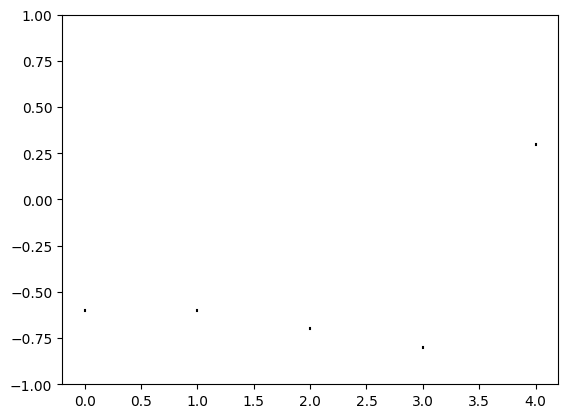

In [81]:
def get_constr(logratios, params, threshold = 1e-6):
    l = logratios
    p = params
    l_max = l.max(0).values
    dl = l - l_max
    w = torch.exp(dl)
    w = w/w.sum(0)
    ws = w.sort(dim=0).values
    wsc = torch.cumsum(ws, 0)
    th = threshold
    w_th = (ws + (wsc < th)).min(0).values
    mask = w >= w_th
    par_max = p.max(dim=0).values
    par_min = p.min(dim=0).values
    constr_min = torch.where(mask.unsqueeze(-1), p, par_max).min(dim=0).values
    constr_max = torch.where(mask.unsqueeze(-1), p, par_min).max(dim=0).values
    return torch.stack([constr_min, constr_max], dim=-1)


bounds = get_constr(logratios[0].logratios, logratios[0].params, 1e-4)[:,0,:]
for i, b in enumerate(bounds):
    plt.plot([i, i], b, 'k')
plt.ylim([-1, 1])
print(bounds)